In [168]:
import pandas as pd
data = pd.read_csv('new_subscription_data.csv')

In [170]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

data.columns

Index(['user_id', 'days_since_signup', 'age', 'payment_activity',
       'login_activity', 'content_view_activity', 'app_update_activity',
       'customer_service_activity', 'account_change_activity',
       'error_report_activity', 'content_download_activity', 'other_activity',
       'subscription_start_date', 'account_issue_history',
       'unsubscribe_reason_email', 'unsubscribe_reason_ad',
       'unsubscribe_reason_content', 'unsubscribe_reason_ui',
       'unsubscribe_reason_login', 'unsubscribe_reason_registration',
       'gender_male', 'activity_count', 'session_count', 'subscription_status',
       'race_asian'],
      dtype='object')

In [172]:
#Check missing data 
df = pd.DataFrame(data)

# Calculate the percentage of missing values in each column
missing_percentages = df.isna().mean() * 100

# Display the missing percentages
print("Missing percentages in each column:")
print(missing_percentages)

Missing percentages in each column:
user_id                            0.0
days_since_signup                  0.0
age                                0.0
payment_activity                   0.0
login_activity                     0.0
content_view_activity              0.0
app_update_activity                0.0
customer_service_activity          0.0
account_change_activity            0.0
error_report_activity              0.0
content_download_activity          0.0
other_activity                     0.0
subscription_start_date            0.0
account_issue_history              0.0
unsubscribe_reason_email           0.0
unsubscribe_reason_ad              0.0
unsubscribe_reason_content         0.0
unsubscribe_reason_ui              0.0
unsubscribe_reason_login           0.0
unsubscribe_reason_registration    0.0
gender_male                        0.0
activity_count                     0.0
session_count                      0.0
subscription_status                0.0
race_asian                  

In [79]:
#standardize continuous variables 
from sklearn.preprocessing import StandardScaler

# Select the columns to standardize
columns_to_standardize = ['age', 'days_since_signup', 'activity_count', 'session_count']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])



In [81]:
#Check VIF
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Function to calculate VIF
def calculate_vif(data):
    vif = pd.DataFrame()
    vif["Variable"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif


# Remove non-predictor columns
X = data.drop(columns=['subscription_start_date', 'subscription_status', 'user_id'])

# Check VIF
vif = calculate_vif(X)
print(vif)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the target outcome
y = data['subscription_status']


                           Variable        VIF
0                 days_since_signup   2.475305
1                               age   1.410995
2                  payment_activity   2.374698
3                    login_activity   1.322662
4             content_view_activity  17.566001
5               app_update_activity   1.471097
6         customer_service_activity   1.335461
7           account_change_activity   4.438057
8             error_report_activity   1.176698
9         content_download_activity   1.415436
10                   other_activity   1.049005
11            account_issue_history   1.535359
12         unsubscribe_reason_email   2.003346
13            unsubscribe_reason_ad  16.998144
14       unsubscribe_reason_content   1.042025
15            unsubscribe_reason_ui   1.109100
16         unsubscribe_reason_login   2.605586
17  unsubscribe_reason_registration   4.360672
18                      gender_male   1.942982
19                   activity_count   2.566663
20           

In [82]:
#Check correlations
columns_to_drop = ['subscription_start_date', 'user_id']
data_dropped = data.drop(columns=columns_to_drop)


correlation_matrix = data_dropped.corr()

# Find pairs with high correlation
high_corr_pairs = [(col1, col2, correlation_matrix.loc[col1, col2])
                   for col1 in correlation_matrix.columns
                   for col2 in correlation_matrix.columns
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

# Remove duplicate pairs
high_corr_pairs = list(set([tuple(sorted(pair[:2])) + (pair[2],) for pair in high_corr_pairs]))

print("Highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair)



Highly correlated pairs:
('content_view_activity', 'unsubscribe_reason_ad', 0.9645620828371715)


In [174]:
#Fit a simple logistic regression model to perform assumption checks
#Drop content_view_activity column as it is highly correlated with the unsubscribe_reason_ad column 

X = data.drop(columns=['subscription_start_date', 'subscription_status', 'user_id', 'content_view_activity'])

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable
y = data['subscription_status']
# Fit the logistic regression model 
logit_model_1 = sm.Logit(y, X)
result = logit_model_1.fit(maxiter=1000)  


# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.123058
         Iterations 8
                            Logit Regression Results                           
Dep. Variable:     subscription_status   No. Observations:                23573
Model:                           Logit   Df Residuals:                    23551
Method:                            MLE   Df Model:                           21
Date:                 Mon, 29 Jul 2024   Pseudo R-squ.:                  0.1172
Time:                         13:48:02   Log-Likelihood:                -2900.9
converged:                        True   LL-Null:                       -3286.1
Covariance Type:             nonrobust   LLR p-value:                1.586e-149
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.9805      0.195    -

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


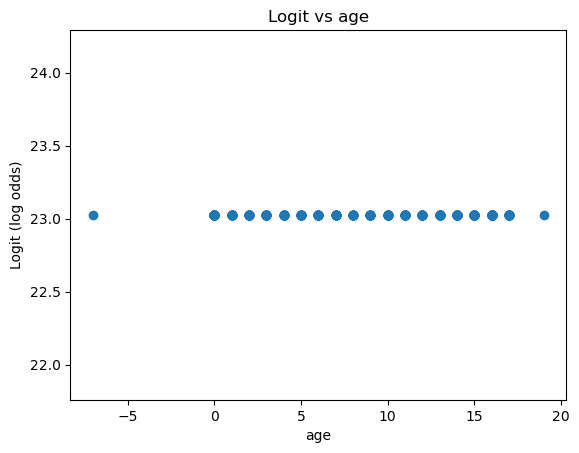

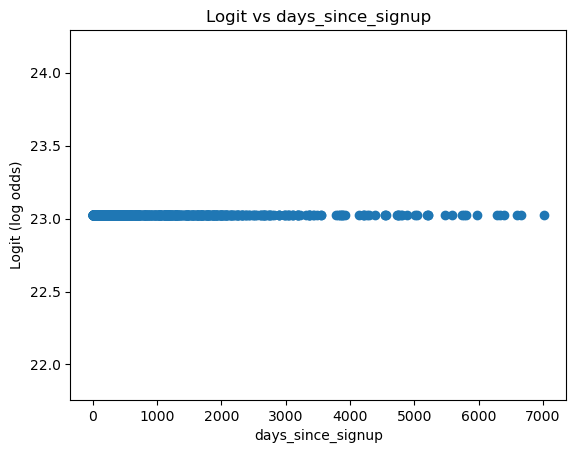

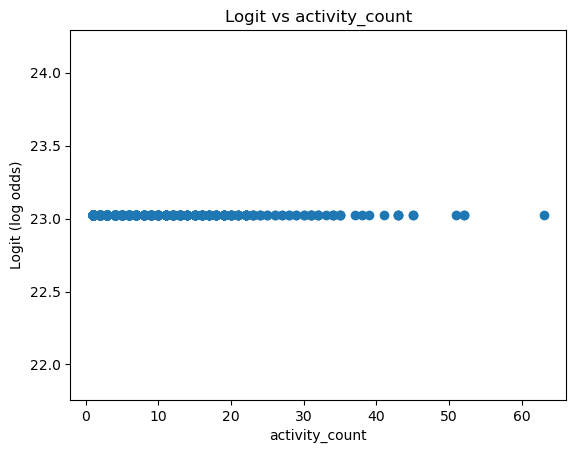

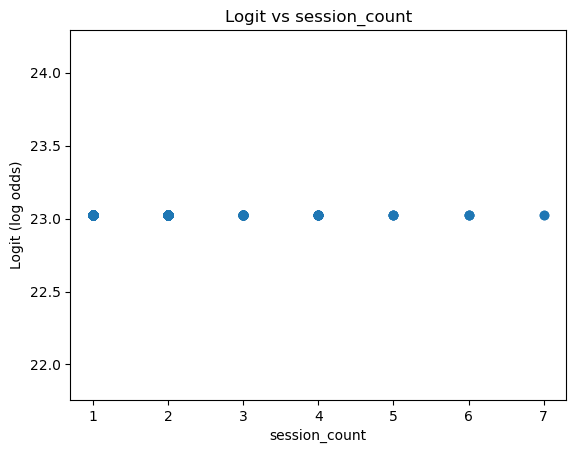

In [176]:

# Assumption Checks
#1. Linearity between continuous predictors and log-odd of the outcome
#plotting log odds versus continuous predictors
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add a small constant to avoid division by zero
data['logit'] = np.log(data['subscription_status'] / (1 - data['subscription_status'] + 1e-10))

# Plot logit vs continuous predictors
for predictor in ['age', 'days_since_signup', 'activity_count', 'session_count']:
    plt.scatter(data[predictor], data['logit'])
    plt.xlabel(predictor)
    plt.ylabel('Logit (log odds)')
    plt.title(f'Logit vs {predictor}')
    plt.show()
    plt.savefig(f'logit_vs_{predictor}.png')  # Save the plot as a PNG file
    plt.close()  # Close the plot to avoid overlapping of figures


In [191]:
#transform the continuous predictors and retest the logistic regression model
#Omit the interaction method as this is an example without theories or previous studies to support 
#Omit  the log method as certain standardized variables have negative values. The log transformation of those variables would result in infinite values
#Omit the sqaure root method as it does not work with negative numbers 

# Polynomial terms
data['age_squared'] = data['age'] ** 2
data['days_since_signup_squared'] = data['days_since_signup'] ** 2
data['activity_count_squared'] = data['activity_count'] ** 2
data['session_count_squared'] = data['session_count'] ** 2





In [193]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2


# Features for the model without polynomial terms
features_model = ['days_since_signup', 'age', 'payment_activity', 'login_activity', 
                  'app_update_activity', 'customer_service_activity', 'account_change_activity', 'error_report_activity',
                  'content_download_activity', 'other_activity', 'account_issue_history', 'unsubscribe_reason_email',
                  'unsubscribe_reason_ad', 'unsubscribe_reason_content', 'unsubscribe_reason_ui', 'unsubscribe_reason_login',
                  'unsubscribe_reason_registration', 'gender_male', 'activity_count', 'session_count', 'race_asian']

# Features for the model with polynomial terms
features_model_poly = features_model + ['age_squared', 'days_since_signup_squared', 'activity_count_squared', 'session_count_squared']

# Fit logistic regression model without polynomial terms
X = data[features_model]
X = sm.add_constant(X)
logit_model = sm.Logit(data['subscription_status'], X).fit()

# Fit logistic regression model with polynomial terms
X_poly = data[features_model_poly]
X_poly = sm.add_constant(X_poly)
logit_model_poly = sm.Logit(data['subscription_status'], X_poly).fit()

# Model summaries
print(logit_model.summary())
print(logit_model_poly.summary())

# Model Comparison
# AIC and BIC comparison
print(f"Model without polynomial terms AIC: {logit_model.aic}, BIC: {logit_model.bic}")
print(f"Model with polynomial terms AIC: {logit_model_poly.aic}, BIC: {logit_model_poly.bic}")

# Likelihood Ratio Test
llf_full = logit_model_poly.llf
llf_reduced = logit_model.llf
lr_stat = 2 * (llf_full - llf_reduced)
df_diff = logit_model_poly.df_model - logit_model.df_model
p_value_lr = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat}, p-value: {p_value_lr}")


#The model with polynomial terms has lower AIC and BIC values compared to the model without polynomial terms, suggesting that it provides a better fit to the data despite its additional complexity.
#The p-value here is extremely small (3.29×10−93.29×10−9), indicating strong evidence that the model with polynomial terms fits the data significantly better than the model without polynomial terms.


Optimization terminated successfully.
         Current function value: 0.123058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122093
         Iterations 8
                            Logit Regression Results                           
Dep. Variable:     subscription_status   No. Observations:                23573
Model:                           Logit   Df Residuals:                    23551
Method:                            MLE   Df Model:                           21
Date:                 Tue, 30 Jul 2024   Pseudo R-squ.:                  0.1172
Time:                         10:18:32   Log-Likelihood:                -2900.9
converged:                        True   LL-Null:                       -3286.1
Covariance Type:             nonrobust   LLR p-value:                1.586e-149
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

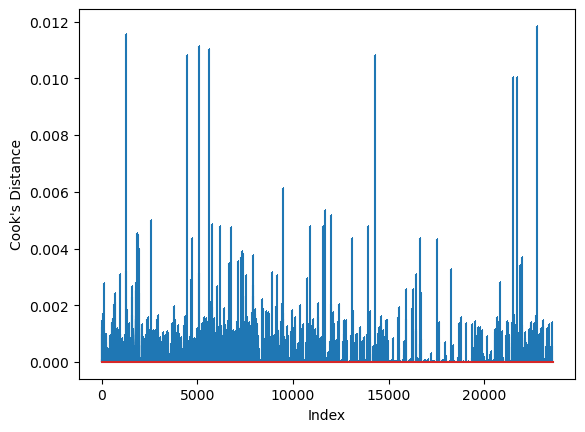

In [119]:
# 2. Check outliers

#index in the plot refer to row number
# Calculate Cook's distance
#None of the cook's distance are more than 1-- thus no influential outliers
influence = logit_model_poly.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's distance
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.show()


In [180]:
data.shape

(23573, 26)

Optimization terminated successfully.
         Current function value: 0.122085
         Iterations 8


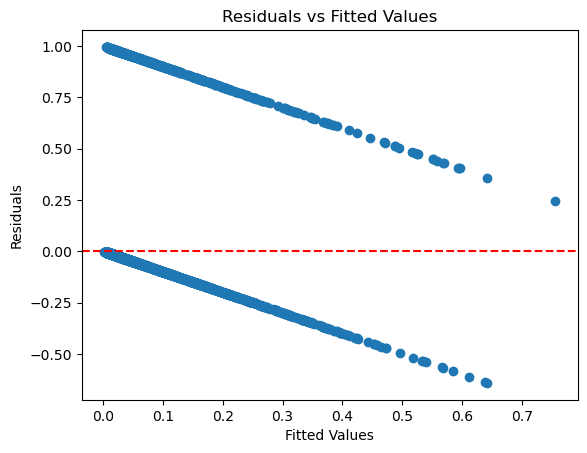

In [123]:
#3 Homoscedasticity
# this means that the variance of the residuals is constant across all levels of the independent variables. 
# In logistic regression, we look at the spread of the predicted probabilities.


# Fit logistic regression model with polynomial terms
X_poly = data[features_model_poly]
X_poly = sm.add_constant(X_poly)
logit_model_poly = sm.Logit(data['subscription_status'], X_poly).fit()

# Get residuals from the model
residuals = logit_model_poly.resid_response

# Get fitted values (predicted probabilities)
fitted_values = logit_model_poly.predict(X_poly)

# Plot residuals vs fitted (i.e., predicted) values
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()




In [186]:
#Check the levels of the outcome
data['subscription_status'].value_counts()

subscription_status
0.0    22834
1.0      739
Name: count, dtype: int64

In [201]:
#1. Logistic regression baseline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature matrix and target variable respectively

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit logistic regression without any class imbalance adjustment
log_reg_baseline = LogisticRegression(max_iter=10000, random_state=42)
log_reg_baseline.fit(X_train, y_train)

# Predict and evaluate
y_pred_baseline = log_reg_baseline.predict(X_test)
print("Baseline Logistic Regression (without SMOTE)")
print(classification_report(y_test, y_pred_baseline))
print("AUC:", roc_auc_score(y_test, y_pred_baseline))


Baseline Logistic Regression (without SMOTE)
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      4584
         1.0       0.20      0.01      0.01       131

    accuracy                           0.97      4715
   macro avg       0.59      0.50      0.50      4715
weighted avg       0.95      0.97      0.96      4715

AUC: 0.5033804937186096


In [199]:

#2. Simple logistic regression with SMOTE 

from imblearn.over_sampling import SMOTE


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Fit logistic regression
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))




              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92      4584
         1.0       0.06      0.30      0.10       131

    accuracy                           0.85      4715
   macro avg       0.52      0.58      0.51      4715
weighted avg       0.95      0.85      0.89      4715

AUC: 0.5806830595633001


In [205]:
#3 logistic regression with class weight adjustment
log_reg_weighted = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
log_reg_weighted.fit(X_train, y_train)

# Predict and evaluate
y_pred_weighted = log_reg_weighted.predict(X_test)
print("Weighted Logistic Regression")
print(classification_report(y_test, y_pred_weighted))
print("AUC:", roc_auc_score(y_test, y_pred_weighted))


Weighted Logistic Regression
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      4584
         1.0       0.08      0.74      0.15       131

    accuracy                           0.77      4715
   macro avg       0.54      0.75      0.51      4715
weighted avg       0.97      0.77      0.84      4715

AUC: 0.7537368610367292


In [207]:
#4 undersampling
from imblearn.under_sampling import RandomUnderSampler


# Apply undersampling to the training data with a custom ratio (0.83:1)
undersampler = RandomUnderSampler(sampling_strategy=0.83, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Fit logistic regression
log_reg_under = LogisticRegression(max_iter=1000, random_state=42)
log_reg_under.fit(X_train_under, y_train_under)

# Predict and evaluate
y_pred_under = log_reg_under.predict(X_test)
print("Undersampling Logistic Regression (0.83:1 ratio)")
print(classification_report(y_test, y_pred_under))
print("AUC:", roc_auc_score(y_test, y_pred_under))


Undersampling Logistic Regression (0.83:1 ratio)
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      4584
         1.0       0.07      0.56      0.12       131

    accuracy                           0.77      4715
   macro avg       0.53      0.67      0.49      4715
weighted avg       0.96      0.77      0.85      4715

AUC: 0.6712952786326153


In [225]:
#1. Lasso model with class weight adjustment 
from sklearn.linear_model import LogisticRegressionCV

# Perform cross-validation to find the best alpha using LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(
    Cs=10,  # Number of values for C (i.e., 1/lambda) to try (default 10)
    cv=5,  # Number of cross-validation folds
    penalty='l1',  # Lasso (L1) regularization
    solver='liblinear',  # Solver that supports L1 regularization
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
log_reg_cv.fit(X_train, y_train)

# Predict and evaluate
y_pred_cv = log_reg_cv.predict(X_test)
print("Lasso Regularized Logistic Regression with Class Weight Adjustment and Cross-Validation")
print(classification_report(y_test, y_pred_cv, zero_division=0))
print("AUC:", roc_auc_score(y_test, y_pred_cv))

# Best parameter found by cross-validation
print("Best C (inverse of regularization strength):", log_reg_cv.C_)




Lasso Regularized Logistic Regression with Class Weight Adjustment and Cross-Validation
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      4584
         1.0       0.08      0.73      0.15       131

    accuracy                           0.76      4715
   macro avg       0.54      0.75      0.50      4715
weighted avg       0.96      0.76      0.84      4715

AUC: 0.7454488229886895
Best C (inverse of regularization strength): [21.5443469]


Feature Importance:
                            Feature    Importance
10                   other_activity  1.126916e+00
21                       race_asian  7.424753e-01
4                    login_activity  6.359555e-01
0                             const -6.073986e-01
6         customer_service_activity  4.726109e-01
12         unsubscribe_reason_email  4.333046e-01
16         unsubscribe_reason_login -4.296700e-01
5               app_update_activity -4.118145e-01
15            unsubscribe_reason_ui -3.614661e-01
9         content_download_activity  3.420717e-01
13            unsubscribe_reason_ad  2.251488e-01
20                    session_count  2.063076e-01
17  unsubscribe_reason_registration -1.876275e-01
7           account_change_activity  1.570631e-01
2                               age -1.565775e-01
18                      gender_male  1.363433e-01
11            account_issue_history -1.054825e-01
3                  payment_activity  9.868565e-02
19                   activity_

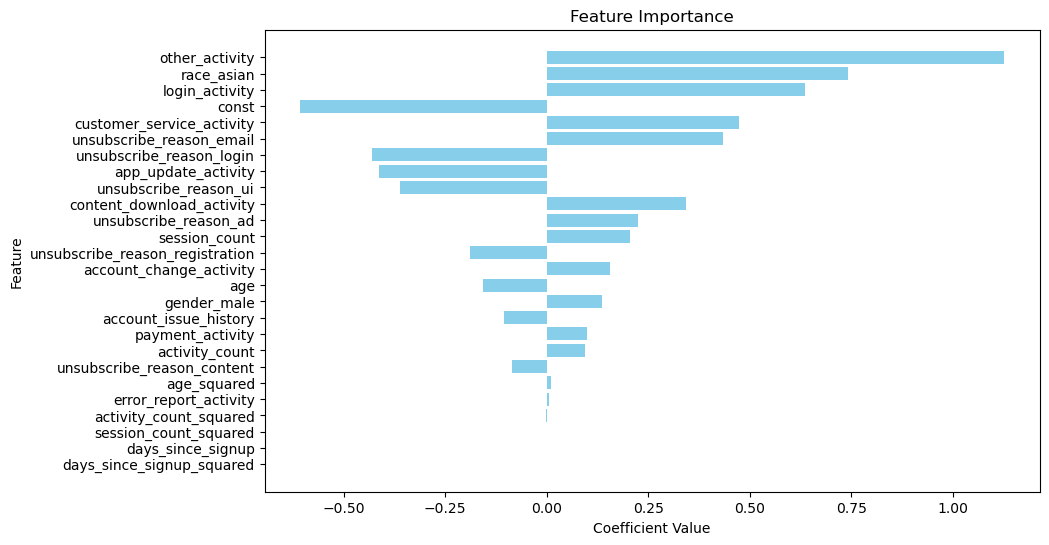

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Get the coefficients of the model
coefficients = log_reg_cv.coef_.flatten()  # Flatten to ensure that the coefficients array is one-dimensional

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': coefficients
})

# Sort by absolute importance
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False)

print("Feature Importance:")
print(feature_importance[['Feature', 'Importance']])

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()



In [235]:
#2. Ridge regression with weight class adjustment 

log_reg_cv = LogisticRegressionCV(
    Cs=10,  # Number of values for C (i.e., 1/lambda) to try (default 10)
    cv=5,  # Number of cross-validation folds
    penalty='l2',  # Ridge (L2) regularization
    solver='liblinear',  # Solver that supports L1 and L2 regularization
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
log_reg_cv.fit(X_train, y_train)

# Predict and evaluate
y_pred_cv = log_reg_cv.predict(X_test)
print("Ridge Regularized Logistic Regression with Class Weight Adjustment and Cross-Validation")
print(classification_report(y_test, y_pred_cv, zero_division=0))
print("AUC:", roc_auc_score(y_test, y_pred_cv))

# Best parameter found by cross-validation
print("Best C (inverse of regularization strength):", log_reg_cv.C_)

Ridge Regularized Logistic Regression with Class Weight Adjustment and Cross-Validation
              precision    recall  f1-score   support

         0.0       0.98      0.26      0.41      4584
         1.0       0.03      0.85      0.06       131

    accuracy                           0.27      4715
   macro avg       0.51      0.56      0.24      4715
weighted avg       0.96      0.27      0.40      4715

AUC: 0.5566257676884749
Best C (inverse of regularization strength): [0.0001]


Feature Importance:
                            Feature    Importance
24           activity_count_squared  8.634182e-04
1                 days_since_signup  1.631626e-04
22                      age_squared -1.600142e-04
2                               age -5.704630e-05
19                   activity_count  3.006419e-05
0                             const -1.191140e-05
20                    session_count -8.548707e-06
25            session_count_squared  8.360396e-06
7           account_change_activity -7.567418e-06
17  unsubscribe_reason_registration -7.484766e-06
16         unsubscribe_reason_login -6.767853e-06
5               app_update_activity -5.349178e-06
18                      gender_male -5.227439e-06
12         unsubscribe_reason_email  4.748866e-06
4                    login_activity  3.033740e-06
11            account_issue_history  2.539948e-06
9         content_download_activity  1.932970e-06
21                       race_asian  1.755496e-06
8             error_report_act

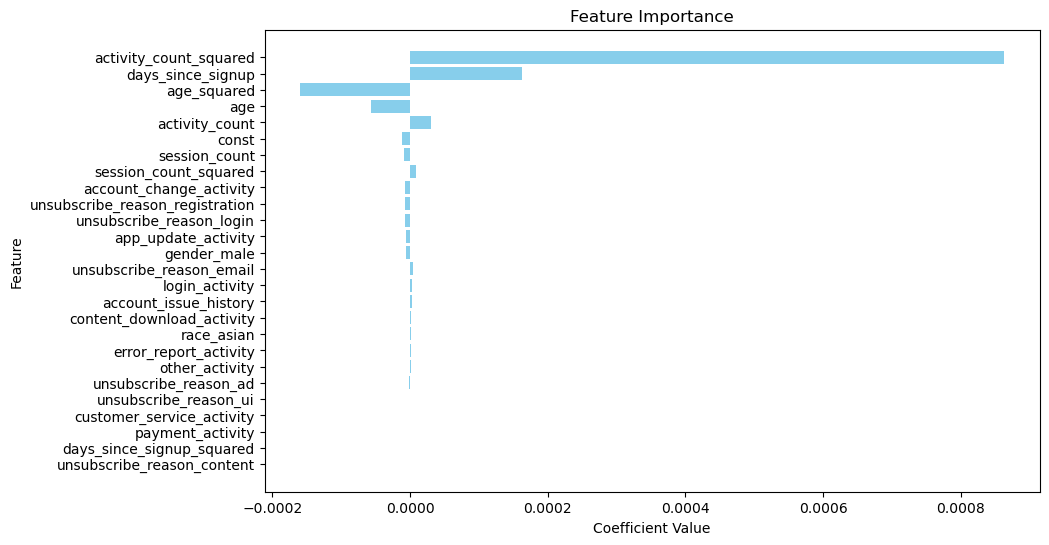

In [237]:
# Feature importance

# Get the coefficients of the model
coefficients = log_reg_cv.coef_.flatten()  # Flatten to ensure that the coefficients array is one-dimensional

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': coefficients
})

# Sort by absolute importance
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False)

print("Feature Importance:")
print(feature_importance[['Feature', 'Importance']])

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

